## Import required packages

In [64]:
import os
import math
import time
import cv2
import csv
import ast
import shutil
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.feature import hog
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage import filters

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn import tree

from scipy.ndimage.measurements import label


%matplotlib inline

C:\Users\Lee Le Xuan\AppData\Local\Temp\ipykernel_32008\3320984788.py:22: DeprecationWarning: Please import `label` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.measurements import label


## Function to extract out region of interests in training images

In [65]:
def extract_roi(source_folder, img, microglia_folder, noise_folder):
  # Load image in grayscale (assuming grayscale HOG features)
  img_read = cv2.imread(source_folder + "/" + img)
  # img_right_colour = cv2.cvtColor(img_read, cv2.COLOR_BGR2RGB)
  #get ellipse parameters from Image_ROIs.csv
  img_name = os.path.splitext(img)[0]
  
  #get coordinates and shape of bounding labels
  bounding_rects = get_row_by_image_name(img_name)
  
  inv_mask = np.zeros(img_read.shape[:2], np.uint8)
  
  count = 0
  
  for index in bounding_rects:
    # Apply ellipse mask to the image
    inv_mask = inv_masking(bounding_rects[index], inv_mask)
    
    # cx = int(bounding_rects[index]["cx"])
    # cy = int(bounding_rects[index]["cy"])
    
    #crop and save image
    cropped_image = crop_image(img_read, bounding_rects[index])
    save_file(cropped_image, img_name, microglia_folder, count)
    count += 1

  #get images of areas that are not microglia 
  inv_mask = cv2.bitwise_not(inv_mask)
  not_microglia = cv2.bitwise_and(img_read, img_read, mask=inv_mask)
  
  plt.imshow(inv_mask)
  plt.show()
  count_noise = 0
  for index_x in range(0, 20):
    for index_y in range(0, 20):
      cx = int(index_x * 101)
      cy = int(index_y * 101)
      cropped_image = crop_image_noise(not_microglia, cx, cy)
      save_file(cropped_image, img_name, noise_folder, count_noise)
      count_noise += 1
  
  return 

def extract_microglia(source_folder, img, microglia_folder):
  # Load image in grayscale (assuming grayscale HOG features)
  img_read = cv2.imread(source_folder + "/" + img)
  # img_right_colour = cv2.cvtColor(img_read, cv2.COLOR_BGR2RGB)
  #get ellipse parameters from Image_ROIs.csv
  img_name = os.path.splitext(img)[0]
  
  #get coordinates and shape of bounding labels
  bounding_rects = get_row_by_image_name(img_name)
  
  count = 0
  
  for index in bounding_rects:
    #crop and save image
    cropped_image = crop_image(img_read, bounding_rects[index])
    save_file(cropped_image, img_name, microglia_folder, count)
    count += 1
       
  return 

def get_row_by_image_name(target_value):

  with open("Image_ROIs.csv", 'r') as csvfile:
    reader = csv.reader(csvfile)
    count = 0
    rois = {}
    for row in reader:
      if row[5] == target_value + ".png" and row[0] == "0":
        rois[count] = {"cx": row[1],
                       "cy": row[2],
                       "w": row[3],
                       "h": row[4]}
        count += 1
    return rois
  return None  # If no row found


def inv_masking(bounding_coords, inv_mask):
  # # Create a mask image with the same size as your original image
  # mask = np.zeros(img.shape[:2], np.uint8)  # Black background
  cx = int(bounding_coords["cx"])
  cy = int(bounding_coords["cy"])
  w = int(bounding_coords["w"])
  h = int(bounding_coords["h"])
  
  # Calculate top-left and bottom-right corners from center
  top_left_x = cx
  top_left_y = int(cy + h)
  bottom_right_x = int(cx + w)
  bottom_right_y = cy
  
  top_left = (top_left_x, top_left_y)
  bottom_right = (bottom_right_x, bottom_right_y)
  
  cv2.rectangle(inv_mask, top_left, bottom_right, 255, -1)
  
  return inv_mask


# Function to clear folders with training images

In [66]:
def clear_folders(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Recursively remove subfolders
        else:
            os.remove(file_path)
            

# Function to crop images, rotate and store them 

In [67]:
def crop_image(img, bounding_coords): 
    
    x = int(bounding_coords["cx"])
    y = int(bounding_coords["cy"])
    w = int(bounding_coords["w"])
    h = int(bounding_coords["h"])
    
    cx = int(x + w/2)
    cy = int(y + h/2)
    
    ystart = cy - 50
    xstart = cx - 50
    #check if microglia is near top of image
    if ystart < 0:
        ystart = 0
    #check if microglia is near most left of image
    if xstart < 0:
        xstart = 0
    
    yend = ystart + 100
    xend = xstart + 100
    
    #check if microglia is near bottom of image
    if yend > 2047:
        yend = 2047
        ystart = yend - 100
        
    #check if microglia is near most right of image
    if xend > 2047:
        xend = 2047
        xstart = xend - 100
    
    # Crop the image
    cropped_img = img[ystart:yend, xstart:xend]
    
    return cropped_img

def crop_image_noise(img, xstart, ystart): 
    
    #check if microglia is near top of image
    if ystart < 0:
        ystart = 0
    #check if microglia is near most left of image
    if xstart < 0:
        xstart = 0
    
    yend = ystart + 100
    xend = xstart + 100
    
    #check if microglia is near bottom of image
    if yend > 2047:
        yend = 2047
        ystart = yend - 100
        
    #check if microglia is near most right of image
    if xend > 2047:
        xend = 2047
        xstart = xend - 100
    
    # Crop the image
    cropped_img = img[ystart:yend, xstart:xend]
    
    return cropped_img

def rotate_and_save(img, filename, folder_name, count):
    save_file(img, filename, folder_name, count)
    
    img_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    count90 = count + 90
    save_file(img_90, filename, folder_name, count90)
    
    img_180 = cv2.rotate(img, cv2.ROTATE_180)
    count180 = count + 180
    save_file(img_180, filename, folder_name, count180)
    
    img_270= cv2.rotate(img_180, cv2.ROTATE_90_CLOCKWISE)
    count270 = count + 270
    save_file(img_270, filename, folder_name, count270)
    

def save_file(img, filename, folder_name, count):
    
    fileName= filename + str(count) + ".jpg"
    folder_path = os.path.join(folder_name, fileName)
    cv2.imwrite(folder_path, img)
    
    

# Wrapper function for pre-processing and saving training images

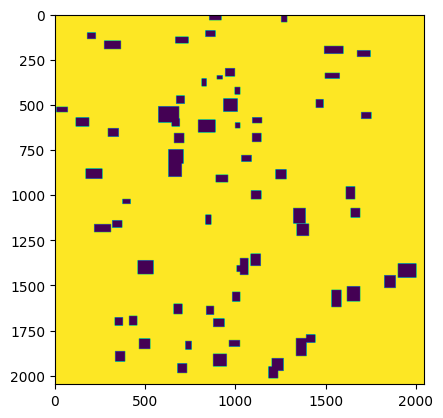

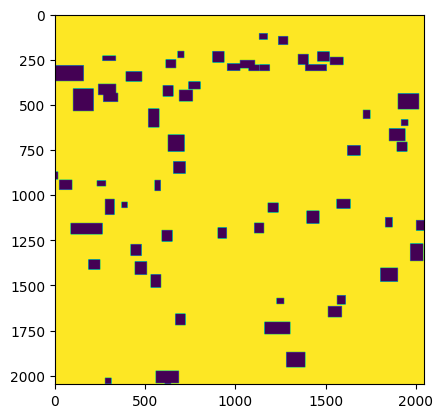

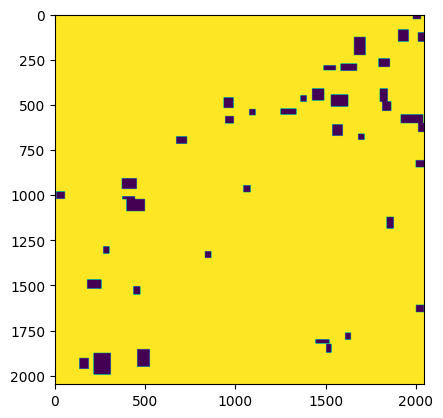

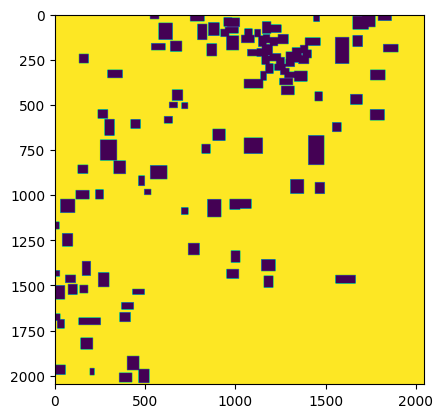

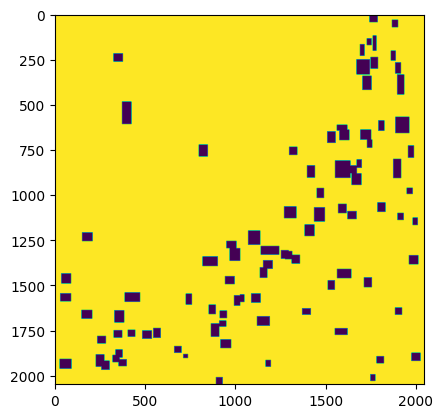

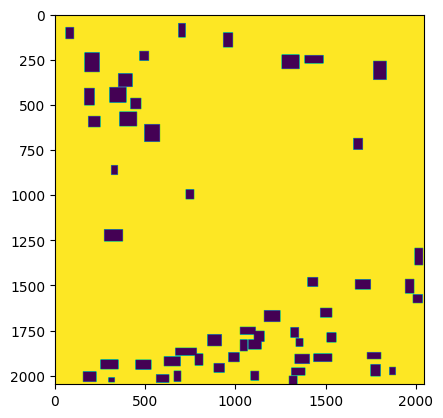

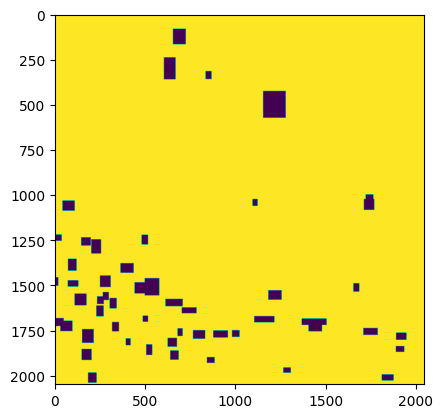

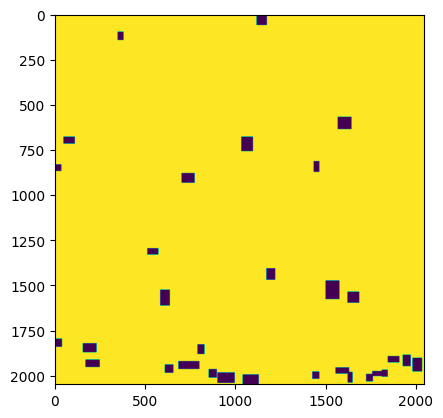

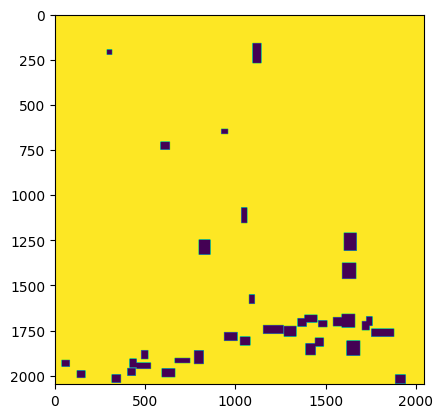

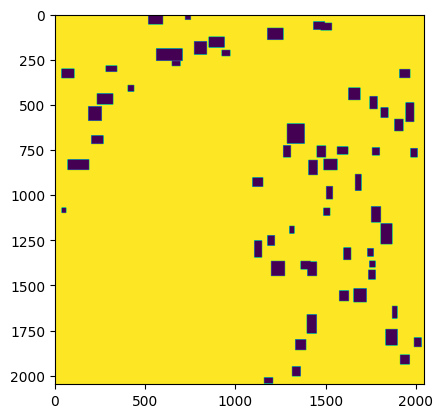

In [68]:
def preprocess_images(source_folder, microglia_folder, noise_folder, hard_negative_folder):
    #clear folders first
    clear_folders(microglia_folder)
    clear_folders(noise_folder)

    # Loop through filenames
    for img in os.listdir(source_folder):
        extract_roi(source_folder, img, microglia_folder, noise_folder)
    
    
preprocess_images("Source_images", "Processed_training_images/Microglia", "Processed_training_images/Noise", "Processed_training_images/Hard_Negative")

## Utility Functions to convert color space and plot image

In [69]:
# Hold the color code name and opencv objects in a dict for easy conversion
colorCodeDict = {
    'RGB2GRAY' : cv2.COLOR_RGB2GRAY,
    'RGB2RGBA' : cv2.COLOR_RGB2RGBA,
    'RGB2BGR' : cv2.COLOR_RGB2BGR,
    'RGB2BGRA' : cv2.COLOR_RGB2BGRA,
    'RGB2HSV' : cv2.COLOR_RGB2HSV,
    'RGB2HLS' : cv2.COLOR_RGB2HLS,
    'RGB2LUV' : cv2.COLOR_RGB2LUV,
    'RGB2YUV' : cv2.COLOR_RGB2YUV,
    'RGB2YCrCb' : cv2.COLOR_RGB2YCrCb,
    
    'BGR2GRAY' : cv2.COLOR_BGR2GRAY,
    'BGR2BGRA' : cv2.COLOR_BGR2BGRA,
    'BGR2RGB' : cv2.COLOR_BGR2RGB,
    'BGR2RGBA' : cv2.COLOR_BGR2RGBA,
    'BGR2HSV' : cv2.COLOR_BGR2HSV,
    'BGR2HLS' : cv2.COLOR_BGR2HLS,
    'BGR2LUV' : cv2.COLOR_RGB2LUV,
    'BGR2YUV' : cv2.COLOR_RGB2YUV,
    'BGR2YCrCb' : cv2.COLOR_RGB2YCrCb
}

def convert_color(img , convCode='RGB2GRAY'):
    """
        return image converted to required colospace
    """
    return cv2.cvtColor(img, colorCodeDict[convCode]);

def plot_img(img, show_stages=False, label=""):
    """
        plot image
    """
    if show_stages:
        print("############################# "+ label +" ##################################")
        plt.imshow(img, cmap='gray')
        plt.show()

## Functions to extract different image features

In [70]:
def bin_spatial(img, size=(32, 32)):
    """
        Return the image color bins
    """
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):
    """
        Return all channel histogram.
    """
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    return np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

def get_hog_features(img, orient, pix_per_cell, cell_per_block,feature_vector=True):
    """
        Return a histogram of oriented gradients using skimage.
    """
    return hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, feature_vector=feature_vector)

## Wrapper function to extract and combine different features

In [71]:
def extract_features(imgs, colorConv, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    """
        Wrapper function to return a bag of features by combining different features extracted with above functions.
    """
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images and extract features
    for file in imgs:
        image = mpimg.imread(file)
        feature_image = convert_color(image, colorConv)
        spatial_features = bin_spatial(feature_image)
        hist_features = color_hist(feature_image)
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    return features

## Functions to train and test different classifiers

In [72]:
def train_SVC(X_train, y_train):
    """
        Function to train an svm.
    """
    svc = svm.LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    return svc

def test_classifier(svc, X_test, y_test):
    """
        Funtion to test the classifier.
    """
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    pred = svc.predict(X_test[0:n_predict])
    actual = y_test[0:n_predict]
    print('My SVC predicts: ', pred)
    print('For these',n_predict, 'labels: ', actual)
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

## Functions to remove duplicate detections and false positives

In [73]:
def add_heat(heatmap, bbox_list):
    """
        Iterate the windows with detected cars and enhance the once with highest detections.
    """
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    """
        Only keep the detections that have a minimum number of pixels.
    """
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    return heatmap

def apply_dynamic_threshold(heatmap, percentile=90):
  """
  Applies a dynamic threshold based on the heatmap percentile.

  Args:
      heatmap: 2D array representing the heatmap intensity.
      percentile (optional): Percentile value (e.g., 90) to use for thresholding.

  Returns:
      thresholded_heatmap: Heatmap with values below the threshold set to 0.
  """
  threshold = np.percentile(heatmap, percentile)
  heatmap[heatmap <= threshold] = 0
  
  return heatmap


def draw_labeled_bboxes(img, labels):
    """
        Draw the boxes on the detected cars
    """
    for i in range(1, labels[1]+1):
        # Find pixels with each car label value
        nonzero = (labels[0] == i).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (255, 0, 0), 6)
    return img


## Use the classifier to detect cars

In [74]:
def find_cars(img, colorConv, svc, X_scaler, orient, pix_per_cell, cell_per_block):
    """
        This function takes in an image, extracts the features from a region of interest and
        runs the predictions on the features.
        Returns a list of co-ordinates where car is detected.
    """
    img = img.astype(np.float32)/255
    img_shape = img.shape
    print(img_shape)
    # Crop the image to remove sky and car bonnet
    ystart = math.floor(img_shape[0]*0)
    ystop = math.floor(img_shape[0]*1)
    img = img[ystart:ystop,:,:]
    plt.imshow(img)
    plt.show()
    #plot_img(img_tosearch, True)
    img = convert_color(img, colorConv)
    # Define blocks and steps as above
    nxblocks = (img.shape[1] // pix_per_cell)-1
    nyblocks = (img.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # set the window size same as the test image size
    window = 100
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    # Compute individual channel HOG features for the entire image
    hog_ch1 = get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block, feature_vector=False)
    hog_ch2 = get_hog_features(img[:,:,1], orient, pix_per_cell, cell_per_block, feature_vector=False)
    hog_ch3 = get_hog_features(img[:,:,2], orient, pix_per_cell, cell_per_block, feature_vector=False)
    on_windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog_ch1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog_ch2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog_ch3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            # Extract the image patch
            subimg = cv2.resize(img[ytop:ytop+window, xleft:xleft+window], (100,100))
            # Get color features
            spatial_features = bin_spatial(subimg)
            # Get histogram feature
            hist_features = color_hist(subimg)
       
            # add all features and Scale them
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))   
            # make a prediction
            test_prediction = svc.predict(test_features)
            # Add to list of windows if car predicted
            if test_prediction == 1:
                xbox_left = int(xleft)
                ytop_draw = int(ytop)
                win_draw = int(window)
                on_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return on_windows

## Set prameters to be used for training the classifier and predictions

In [75]:
colorConv = 'BGR2HSV'
hog_channel = "ALL"
orient = 9
pix_per_cell = 8
cell_per_block = 2
recent_heatmaps = deque(maxlen=10)

## Setup training and validation data

In [76]:
def setup_train_data(colorConv, orient, pix_per_cell, cell_per_block, hog_channel):
    """
        Setup data for classifier training. 
        Shuffle the data and split it in training and testing set.
    """
    microglia = []
    for microglia_img in os.listdir("Processed_training_images/Microglia"):
        microglia_path = "Processed_training_images/Microglia" + "/" + microglia_img
        microglia.append(microglia_path)
    
    noise = []
    for noise_img in os.listdir("Processed_training_images/Noise"):
        noise_path = "Processed_training_images/Noise" + "/" + noise_img
        noise.append(noise_path)

    microglia_features = extract_features(microglia, colorConv, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel)
    noise_features = extract_features(noise, colorConv, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    # Create an array stack of feature vectors
    X = np.vstack((microglia_features, noise_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    # Define the labels vector
    y_train = np.hstack((np.ones(len(microglia_features)), np.zeros(len(noise_features))))
    # shuffle the data
    #X_train, y_train = shuffle(scaled_X, y_train)
    # Split up data into randomized training and test sets
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y_train, test_size=0.2, random_state=2)
    return X_train, X_test, y_train, y_test, X_scaler

print('Preparing training data...')
X_train, X_test, y_train, y_test, X_scaler = setup_train_data(colorConv, orient, 
                                                              pix_per_cell, cell_per_block, hog_channel)
print("Number of training examples =", len(X_train))
print("Number of testing examples =", len(X_test))

Preparing training data...
Number of training examples = 3679
Number of testing examples = 920


## Train the classifier

In [77]:
print('Training Classifier...')
svc = train_SVC(X_train, y_train)


Training Classifier...
9.53 Seconds to train SVC...


## Test the classifier

In [78]:
print('Testing Classifier...')
test_classifier(svc, X_test, y_test)
#test_classifier(clf, X_test, y_test)

Testing Classifier...
Test Accuracy of SVC =  0.8815
My SVC predicts:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
For these 10 labels:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.001 Seconds to predict 10 labels with SVC


## Wraper function to preprocess image run the classifier and post processing the result.

In [79]:
def process_img(img, threshhold=1.5, show_stages=False):
    """
        Wrapper function to perform all the processing.
    """
    
    # get the windows where the classifier predicts car
    hot_windows = find_cars(img, colorConv, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    if show_stages:
        img1 = np.copy(img)
        for bbox in hot_windows:
            cv2.rectangle(img1, bbox[0], bbox[1], (255, 0, 0), 6)
        plot_img(img1, show_stages, "All detections")
    
    # Highlight the windows
    heat = np.zeros_like(img[:,:,0]).astype(float)
    heat = add_heat(heat,hot_windows)
    plot_img(heat, show_stages, "After Applying heat")
    
    # Append the detections to detections from last n frames
    recent_heatmaps.append(heat)
    
    # Take the mean of last n frames as discard the windows that are below the threshold
    heatmap = apply_dynamic_threshold(np.mean(recent_heatmaps, axis=0),threshhold)
    plot_img(heatmap, show_stages, "After threshold")
    
    # Add labels to remaning detections
    labels = label(heatmap)
    
    print(labels)
    # Draw boxes on the cars and return the image
    return draw_labeled_bboxes(np.copy(img), labels), heatmap

# Hard Negative Mining
### Functions to compare selected areas

In [80]:
# get inverse mask of microglia areas in grayscale

def microglia_mask_binary(source_folder, img):
  # Load image in grayscale (assuming grayscale HOG features)
  img_read = cv2.imread(source_folder + "/" + img)
  # img_right_colour = cv2.cvtColor(img_read, cv2.COLOR_BGR2RGB)
  #get ellipse parameters from Image_ROIs.csv
  img_name = os.path.splitext(img)[0]
  
  #get coordinates and shape of bounding labels
  bounding_rects = get_row_by_image_name(img_name)
  
  inv_mask = np.zeros(img_read.shape[:2], np.uint8)
  
  for index in bounding_rects:
    # Apply ellipse mask to the image
    inv_mask = inv_masking(bounding_rects[index], inv_mask)
    
  #get images of areas that are not microglia 
  inv_mask = cv2.bitwise_not(inv_mask)
  not_microglia = cv2.bitwise_and(img_read, img_read, mask=inv_mask)
  mask_binary = cv2.threshold(inv_mask, 1, 255, cv2.THRESH_BINARY)[1]
  
  return mask_binary, img_name, not_microglia
    
# do and function with heatmap 

def get_hard_negative_heatmap(labelled_mask, predicted_heatmap):
    predicted_heatmap_uint8 = predicted_heatmap.astype(np.uint8)
    predicted_heatmap_binary = cv2.threshold(predicted_heatmap_uint8, 1, 255, cv2.THRESH_BINARY)[1]
    print("predicted_heatmap_binary")
    print(predicted_heatmap_binary)
    print("labelled mask")
    print(labelled_mask)
    hard_negative_heatmap = cv2.bitwise_and(labelled_mask, labelled_mask, mask=predicted_heatmap_binary)
    
    return hard_negative_heatmap

# so its nand function of heatmap and microglia areas (get areas that are not and)
# get labels of the areas
def get_hard_negative_images(img, heatmap, window_size, filename):

    labels = label(heatmap)
    for i in range(1, labels[1]+1):
        # Find pixels with each car label value
        nonzero = (labels[0] == i).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        crop_image_hard_negative(img, np.min(nonzerox), np.min(nonzeroy), np.max(nonzerox), np.max(nonzeroy), window_size, filename)
        
  
def crop_image_hard_negative(img, xmin, ymin, xmax, ymax, window_size, filename): 
  
  xstart = xmin
  ystart = ymin
  
  yend = ystart + window_size 
  xend = xstart + window_size 
  
  if yend > 2047:
    yend = 2047
    ystart = yend - window_size
  
  if xend > 2047:
    xend = 2047
    xstart = xend - window_size
    
  #do a first crop 
  # Crop the image
  cropped_img = img[ystart:yend, xstart:xend]
  
  filename += "_hard_negative"
  
  count = 0
  save_file(cropped_img, filename, "Processed_training_images/Hard_Negative", count)
  save_file(cropped_img, filename, "Processed_training_images/Noise", count)
  
  
  while yend < ymax:
    ystart = yend
    yend = ystart + window_size 
    
    #loop once to get row
    while xend < xmax:
      xstart = xend
      xend = xstart + window_size 
      count += 1
      
      if xend > 2047:
        xend = 2047
        xstart = xend - window_size
      cropped_img = img[ystart:yend, xstart:xend]
      
      save_file(cropped_img, filename, "Processed_training_images/Hard_Negative", count)
      save_file(cropped_img, filename, "Processed_training_images/Noise", count)
      
    # loop to get column 
    count += 1
    cropped_img = img[ystart:yend, xstart:xend]
    save_file(cropped_img, filename, "Processed_training_images/Hard_Negative", count)
    save_file(cropped_img, filename, "Processed_training_images/Noise", count)
    
  #to take care of ends
  if yend >= ymax and xend <= xmax:
      yend = ymax
      ystart = yend - window_size
      
      while xend < xmax:
        xstart = xend
        xend = xstart + window_size 
        count += 1
        
        if xend > 2047:
          xend = 2047
          xstart = xend - window_size
          
        cropped_img = img[ystart:yend, xstart:xend]
        save_file(cropped_img, filename, "Processed_training_images/Hard_Negative", count)
        save_file(cropped_img, filename, "Processed_training_images/Noise", count)
        
  #check if microglia is greater than xend
  if xend >= xmax and yend <= ymax:
      xend = xmax
      xstart = xend - window_size
      
      while yend < ymax:
        ystart = yend
        yend = ystart + window_size 
        count += 1
        
        if yend > 2047:
          yend = 2047
          ystart = yend - window_size
          
        cropped_img = img[ystart:yend, xstart:xend]
        save_file(cropped_img, filename, "Processed_training_images/Hard_Negative", count)
        save_file(cropped_img, filename, "Processed_training_images/Noise", count)



### Function to run all and get hard_negatives

In [81]:
def get_hard_negatives(source_folder, img, predicted_heatmap, window_size):
    mask_binary, filename, not_microglia = microglia_mask_binary(source_folder, img)
    print("binary mask")
    print(mask_binary)
    plt.imshow(mask_binary)
    plt.show()
    hard_negative_heatmap  = get_hard_negative_heatmap(mask_binary, predicted_heatmap)
    print("hard negative heatmap")
    plt.imshow(hard_negative_heatmap)
    plt.show()
    plt.imshow(not_microglia)
    plt.show()
    get_hard_negative_images(not_microglia, hard_negative_heatmap, window_size, filename)
    

# Run all and repeat to mine hard negatives

In [82]:
test_dir = "test_images"
hard_negative_dir = "hard_negative_training"
hard_negative_folder = "Processed_training_images/Hard_Negative"

In [83]:
def run_all(hard_negative_dir, hard_negative_folder):
    clear_folders(hard_negative_folder)
    #predict and get hard negatives first + add it to file
    for test_image in os.listdir(hard_negative_dir):
        print()
        print("------------------------------"+test_image+"---------------------------------")
        recent_heatmaps = deque(maxlen=10)
        img = cv2.imread(hard_negative_dir +"/" + test_image)
        img_right_colour = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        out_img, predicted_heatmap = process_img(img_right_colour, 95, True)
        plot_img(out_img, True, "Final Result")
        print()
        
        print("------------------------------"+test_image+"---------------------------------")
        #extract hard negatives and add them into noise and hard_negative folder
        get_hard_negatives(hard_negative_dir, test_image, predicted_heatmap, 100)
        #add microglia training data
        extract_microglia(hard_negative_dir, test_image, "Processed_training_images/Microglia")
        print()
        print("------------------------------"+test_image+"---------------------------------")
        #train model 
        print('Preparing training data...')
        X_train, X_test, y_train, y_test, X_scaler = setup_train_data(colorConv, orient, pix_per_cell, cell_per_block, hog_channel)
        print("Number of training examples =", len(X_train))
        print("Number of testing examples =", len(X_test))
        print()
        
        print("------------------------------"+test_image+"---------------------------------")
        print('Training Classifier...')
        svc = train_SVC(X_train, y_train)

        print('Testing Classifier...')
        test_classifier(svc, X_test, y_test)
        #test_classifier(clf, X_test, y_test)
        


------------------------------11_s44.png---------------------------------
(2048, 2048, 3)


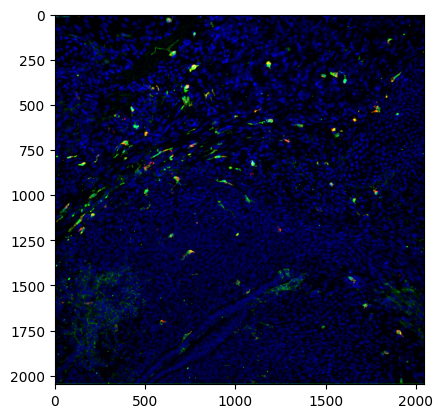

############################# All detections ##################################


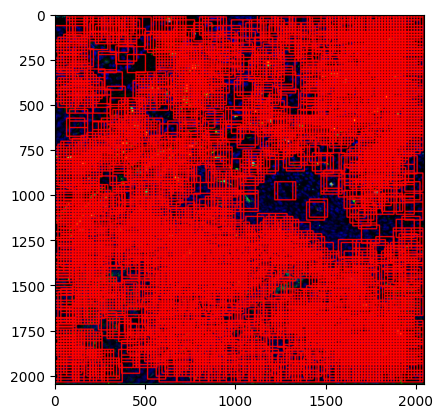

############################# After Applying heat ##################################


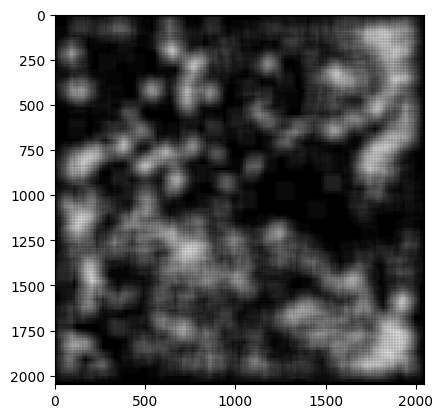

############################# After threshold ##################################


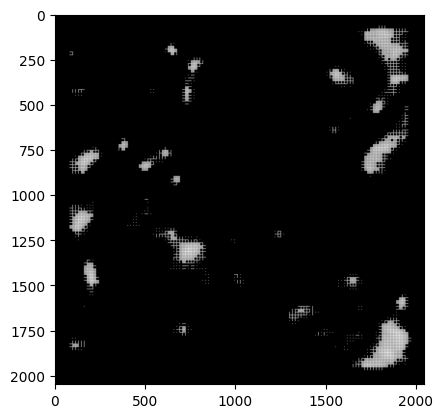

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 329)
############################# Final Result ##################################


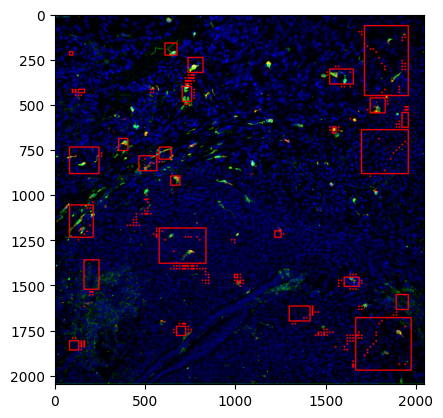


------------------------------11_s44.png---------------------------------
binary mask
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


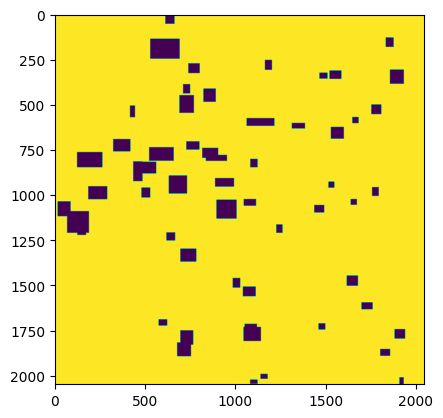

predicted_heatmap_binary
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
labelled mask
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
hard negative heatmap


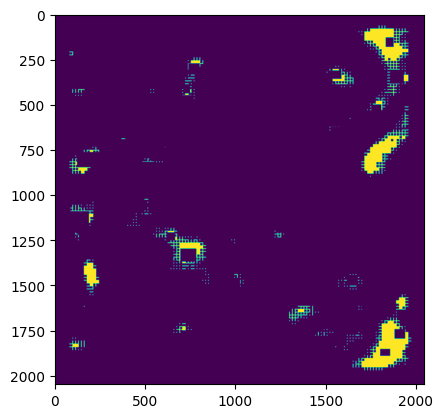

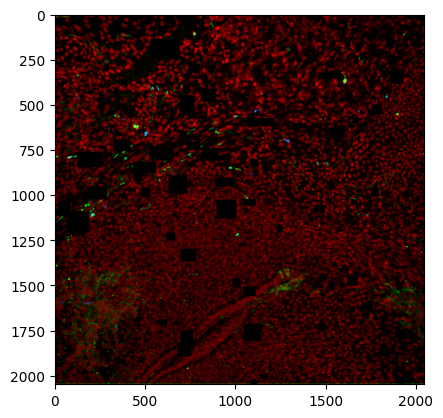


------------------------------11_s44.png---------------------------------
Preparing training data...
Number of training examples = 3729
Number of testing examples = 933

------------------------------11_s44.png---------------------------------
Training Classifier...
9.87 Seconds to train SVC...
Testing Classifier...
Test Accuracy of SVC =  0.9057
My SVC predicts:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
For these 10 labels:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
0.001 Seconds to predict 10 labels with SVC

------------------------------12_s45.png---------------------------------
(2048, 2048, 3)


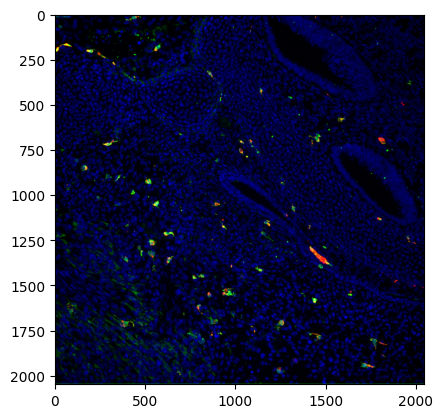

############################# All detections ##################################


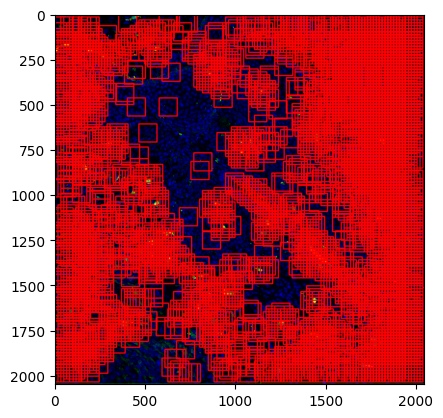

############################# After Applying heat ##################################


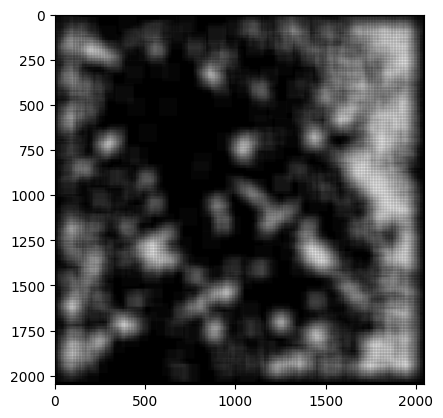

############################# After threshold ##################################


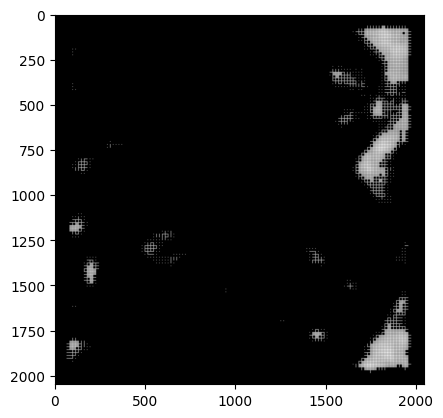

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 379)
############################# Final Result ##################################


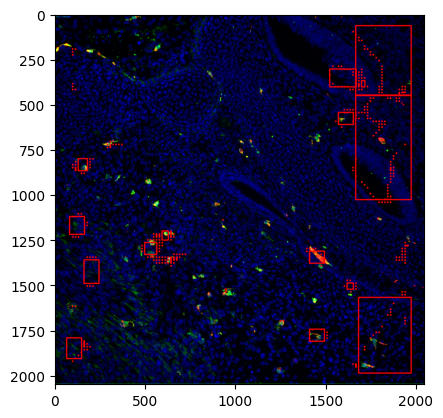


------------------------------12_s45.png---------------------------------
binary mask
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


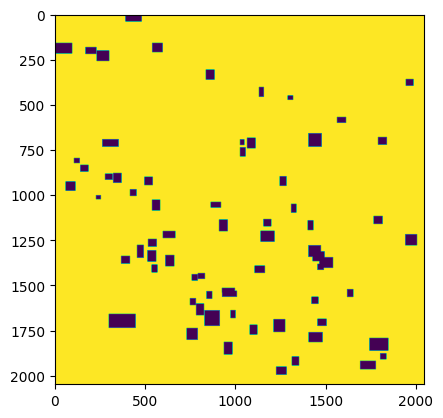

predicted_heatmap_binary
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
labelled mask
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
hard negative heatmap


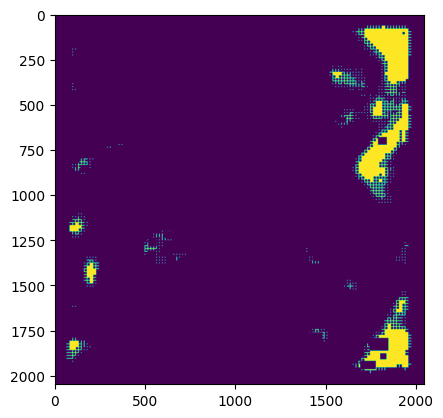

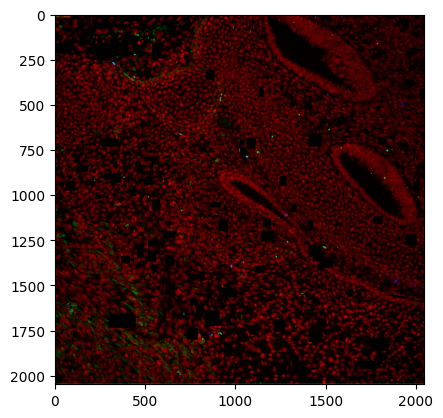


------------------------------12_s45.png---------------------------------
Preparing training data...


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4015,) + inhomogeneous part.

In [84]:
run_all(hard_negative_dir, hard_negative_folder)

# Prediction

In [ ]:
for test_image in os.listdir(test_dir):
    print()
    print("------------------------------"+test_image+"---------------------------------")
    recent_heatmaps = deque(maxlen=10)
    img = cv2.imread(test_dir +"/" + test_image)
    img_right_colour = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    out_img, predicted_heatmap = process_img(img_right_colour, 95, True)
    plot_img(out_img, True, "Final Result")
    print()

# Confusion Matrix Calculations


In [ ]:
def confusion_matrix(tp, fp, fn):
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    # accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    print("Precision: " + str(precision))
    print("Recall: " + str(recall))
    # print("Accuracy: " + accuracy)
    print("F1-score: " + str(f1_score))
    
# Analysis:
# Positives: 36
# True positives: 20
# False negative: 6
# False positive: 16

# Analysis:
# Positives: 52
# True positives: 32
# False positives: 20
# False negatives: 4


print("Overall")
confusion_matrix(52, 36, 20)
print("////////////////////////////////////////////////////////////")
print("picture 1")
confusion_matrix(32,20,4)
print("////////////////////////////////////////////////////////////")
print("picture 2")
confusion_matrix(20, 16, 6)
